In [43]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interactive, interact
from matplotlib import animation, rc
import ipywidgets as widgets
from scipy import fft as fft
from scipy import signal as sig
import pandas as pd
import sys
np.set_printoptions(threshold=sys.maxsize)

<IPython.core.display.Javascript object>


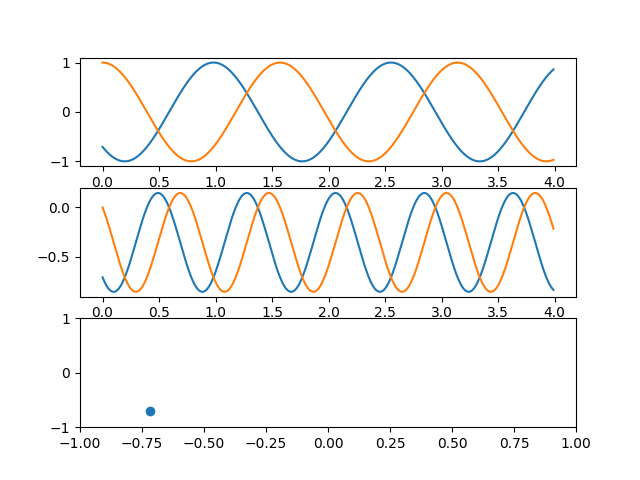

In [2]:
#Understanding Quadrature Demod
%matplotlib notebook

t = np.arange(0, 4, .01)
x = np.cos(4*t + 3*np.pi/4)
x2 =np.cos(4*t)
plt.figure(3)
#Plot original signal
plt.subplot(311)
plt.plot(t, x, t, x2)

#Implement Quadrature demod
comp_data = (x*np.cos(4*t) + 1j*np.sin(4*t)*x)
plt.subplot(312)
plt.plot(t, comp_data.real, t, comp_data.imag)

#Plot Symbol
plt.subplot(313)
plt.xlim(-1,1)
plt.ylim(-1,1)
symb = np.sum(comp_data)
symb = symb / abs(symb)
plt.scatter(symb.real, symb.imag)
plt.show()

<IPython.core.display.Javascript object>


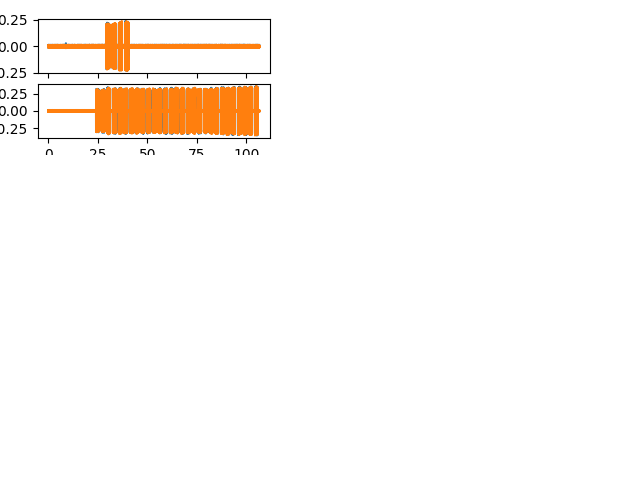

<IPython.core.display.Javascript object>

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [13]:
#Import Data
raw0 = np.fromfile(open("open_press0"), dtype=np.complex64)
raw1 = np.fromfile(open("open_press1"), dtype=np.complex64)
int0 = np.fromfile(open("open_press_int"), dtype=np.complex64)
#Constants
fs = 32000 #32k Samples/seconds

#raw0 with respect to time
T0 = np.linspace(0.0, raw0.size/fs, raw0.size)
T1 = np.linspace(0.0, raw0.size/fs, raw1.size)
T_int = np.linspace(0.0, int0.size/fs, int0.size)

T = T0

%matplotlib notebook
plt.figure(0)
plt.subplot(211)
plt.plot(T, raw0.real, T, raw0.imag)
plt.subplot(212)
plt.plot(T1, raw1.real, T1, raw1.imag)


plt.figure(1)
plt.plot(T_int, int0)
plt.show()


<IPython.core.display.Javascript object>


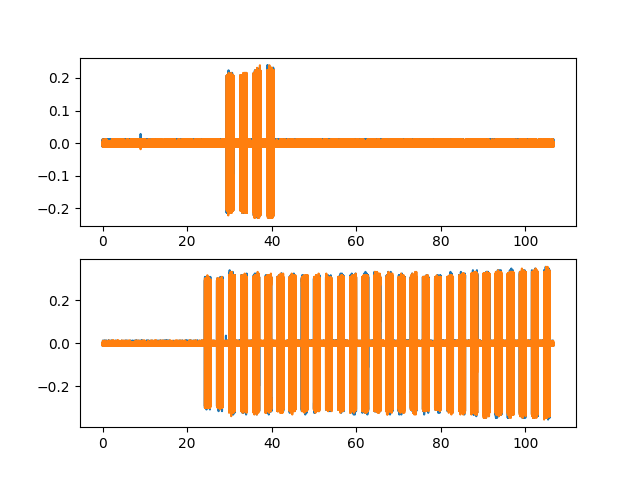

In [14]:
#Determine general shape of signal based on 2 different samples where the open button was pressed for different 
#Lengths of time. The open button was pressed for less time in raw0 than raw1.
%matplotlib notebook
plt.figure(1)
#PLT raw0
x_smpl_arr = range(raw0.size)
plt.subplot(211)
plt.plot(T, raw0.real, T, raw0.imag)
#PLT raw1
x_smpl_arr = range(raw1.size)
plt.subplot(212)
plt.plot(T1, raw1.real, T1, raw1.imag)
plt.show()



<IPython.core.display.Javascript object>


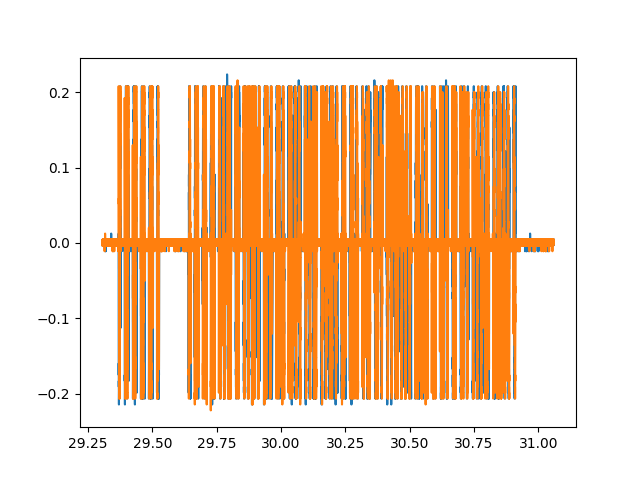

In [15]:
#Now that we can hypothosize that the remote sends a same/similar message the longer the button is pressed, we can 
#isolatethe message based on the first occurence 
#Maybe optimal method is to use derivative like what is used to isolate bits

def isolatePacket(raw_data):
    SMPL_BUFF = 2000 # buffer to 
    PCKT_SIZE_EST = 50000
    tx =abs(raw_data)>.05  
    msg_loc = np.where(tx == True)[0] #locatoins where value non-zero
    start_tx = msg_loc[0] - SMPL_BUFF #I know this is dangerous but I'm a badass
    
    #find end of packet
    diff_msg_loc = np.roll(msg_loc, 1)
    diff_msg_loc[0] = msg_loc[0]
    temp = np.where((msg_loc - diff_msg_loc) > PCKT_SIZE_EST)[0]
    end_tx = msg_loc[temp[0]] - PCKT_SIZE_EST + SMPL_BUFF
  
    return [start_tx, end_tx]

%matplotlib notebook
pkt_size = isolatePacket(raw0)
raw_pkt = raw0[pkt_size[0]:pkt_size[1]]
x_raw_pkt = T[pkt_size[0]:pkt_size[1]]
plt.figure(2)
plt.plot(x_raw_pkt, raw_pkt.real, x_raw_pkt, raw_pkt.imag)
plt.show()

1900 2500


<IPython.core.display.Javascript object>


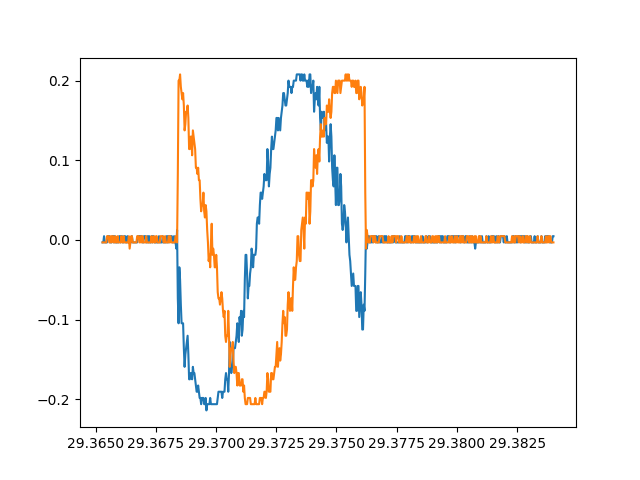

<IPython.core.display.Javascript object>


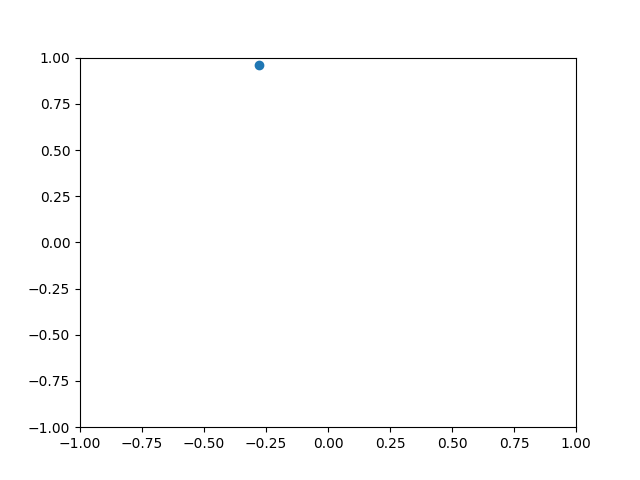

In [16]:
#Isolate bits
#maybe another/smarter way to do this is to use the derivative
#Based on graphical observation of the graph above, I found 4 bit lengths in # of samples. I will average to get an
#    estimated bit length

bLeng_raw = [9.415e5-4.205e5, 9.411e5-9.404e5, 9.431e5-9.425e5, 9.441e5-9.435e5]
BLENG_EST = int (np.sum(bLeng_raw) / len(bLeng_raw))
BLENG_EST = 400

ZERO_TRESH = .05    #Determined graphically. Threshold to determine b/t zero and non-zero
SMPL_BUFF = 100 # buffer to add at the end of the bit for optimal viewing

#Method 1 using zero threshold
tx =abs(raw_pkt)>ZERO_TRESH 
bit_loc = np.where(tx == True)[0] #locations where value non-zero
start_tx = bit_loc[0] - SMPL_BUFF #I know this is dangerous but I'm a badass
end_tx = start_tx + BLENG_EST + 2*SMPL_BUFF

print(start_tx, end_tx)
raw_bit = raw_pkt[start_tx:end_tx]
x_raw_bit = x_raw_pkt[start_tx:end_tx]


%matplotlib notebook
plt.figure(4)
plt.plot(x_raw_bit, raw_bit.real, x_raw_bit, raw_bit.imag)
plt.show()

plt.figure(5)
plt.xlim(-1,1)
plt.ylim(-1,1)
symb = np.sum(raw_bit)
symb = symb / abs(symb)
plt.scatter(symb.real, symb.imag)
plt.show()

   

<IPython.core.display.Javascript object>


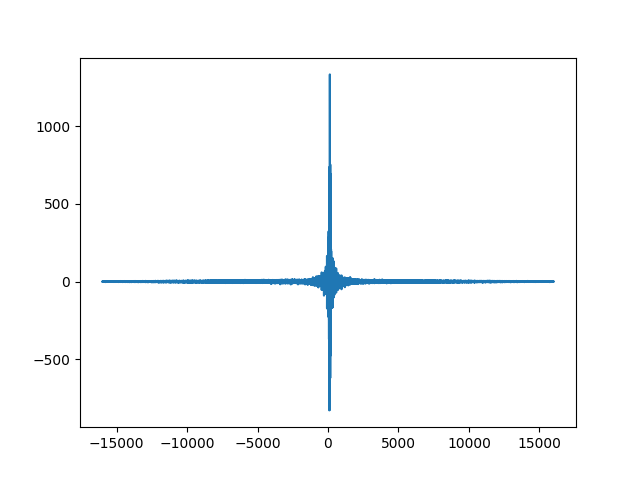

[ 0.          0.57052185  1.1410437  ... -1.71156555 -1.1410437
 -0.57052185]


/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [17]:
#I want to see what this looks like in freq domain
N = 630000000
fft_pkt = fft.fft(raw_pkt)
#fft_pkt = fft.fft(np.cos(2*np.pi*T*5000))

%matplotlib notebook
plt.figure(9)
xf = fft.fftfreq(raw_pkt.size, d=1/fs)
plt.plot(xf, fft_pkt)

print(xf)

In [18]:
def isolateBitThresh(pkt):
    BLENG_EST = 250     #Bit length estimate in samples
    ZERO_TRESH = .05    #Determined graphically. Threshold to determine b/t zero and non-zero
    SMPL_BUFF = 0 # buffer to add at the end of the bit for optimal viewing

    #pkt = pkt[start:]    #TODO needs to be made more efficient
    tx =abs(pkt)>ZERO_TRESH 
    bit_loc = np.where(tx == True)[0] #locations where value non-zero
    start_tx = bit_loc - SMPL_BUFF #I know this is dangerous but I'm a badass
    end_tx = bit_loc + BLENG_EST + SMPL_BUFF
    bit_bounds = [start_tx, end_tx]
    return (start_tx, end_tx)


[ 2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  2011
  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023
  2024  2025  2026  2027  2028  2029  2030  2031  2032  2033  2034  2035
  2036  2037  2038  2039  2040  2041  2042  2043  2044  2045  2046  2047
  2048  2049  2050  2051  2052  2053  2054  2055  2056  2057  2058  2059
  2060  2061  2062  2063  2064  2065  2066  2067  2068  2069  2070  2071
  2072  2073  2074  2075  2076  2077  2078  2079  2080  2081  2082  2083
  2084  2085  2086  2087  2088  2089  2090  2091  2092  2093  2094  2095
  2096  2097  2098  2099  2100  2101  2102  2103  2104  2105  2106  2107
  2108  2109  2110  2111  2112  2113  2114  2115  2116  2117  2118  2119
  2120  2121  2122  2123  2124  2125  2126  2127  2128  2129  2130  2131
  2132  2133  2134  2135  2136  2137  2138  2139  2140  2141  2142  2143
  2144  2145  2146  2147  2148  2149  2150  2151  2152  2153  2154  2155
  2156  2157  2158  2159  2160  2161  2162  2163  2

<ipython-input-44-202ce2e44cc1>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  symb[i] = np.sum(raw_pkt[bounds[0][i]:bounds[1][i]])
<ipython-input-44-202ce2e44cc1>:17: RuntimeWarning: invalid value encountered in double_scalars
  symb[i] = symb[i] / abs(symb[i])


<IPython.core.display.Javascript object>


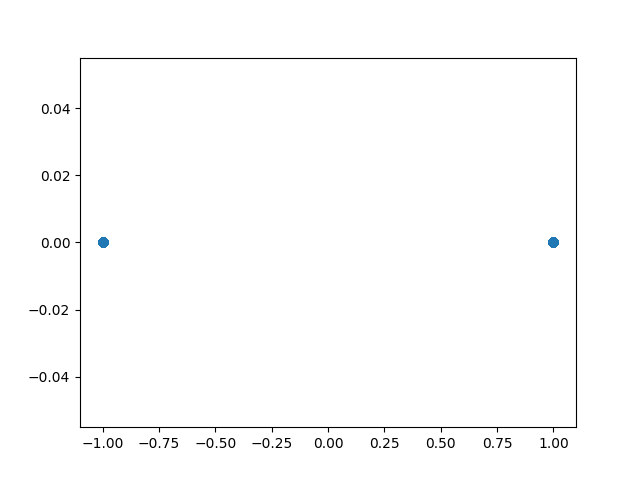

In [44]:
#Here we turn packets to symbols
#symb = np.array(0, dtype=complex, ndmin=1)
bounds=(0,0)
i=0
#while bounds[1] >= 0:
#    bounds = isolateBitThresh(raw_pkt, i)
#    raw_bit = raw_pkt[bounds[0]:bounds[1]]
#    symb = np.append(symb, np.sum(raw_bit) / abs(raw_bit))
#    print(bounds, i)
#    i = i+1
bounds = isolateBitThresh(raw_pkt)

print(bounds[0])
symb = np.empty(bounds[0].size)
for i in range(bounds[0].size):
    #integrate and dump
    symb[i] = np.sum(raw_pkt[bounds[0][i]:bounds[1][i]])
    symb[i] = symb[i] / abs(symb[i])



%matplotlib notebook




#plt.figure(5)
#plt.subplot(211)
#plt.plot(range(symb[0].size), symb[0].real, range(symb[0].size), symb[0].imag)
#plt.subplot(212)
#plt.plot(range(symb[1].size), symb[1].real, range(symb[1].size), symb[1].imag)
#plt.show()

plt.figure(6)
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.scatter(symb.real, symb.imag)
plt.show()

In [34]:
print(symb.size)
print(symb[0].real)

1


IndexError: invalid index to scalar variable.

<IPython.core.display.Javascript object>


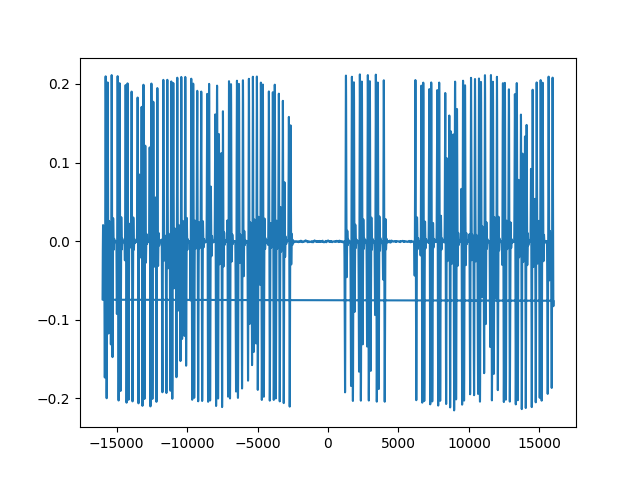

<IPython.core.display.Javascript object>


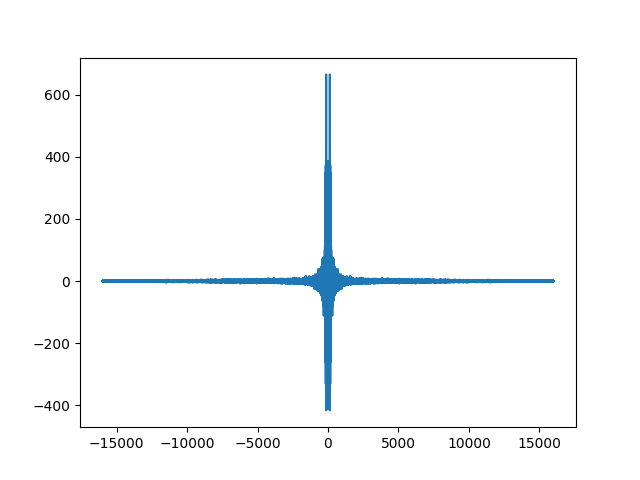

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


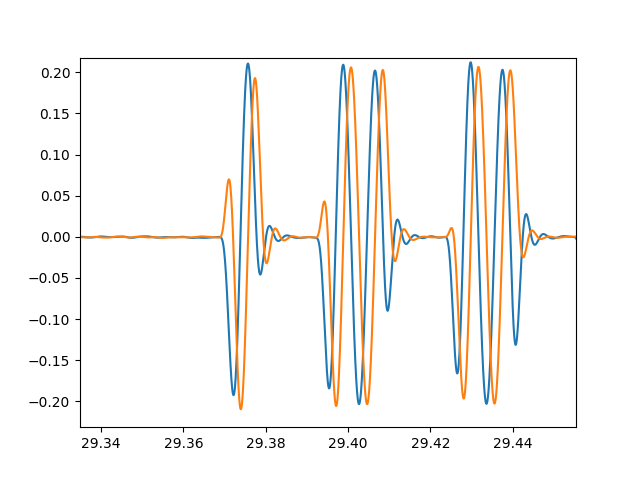

In [106]:
#Low pass filter using butterworth. Cutoff freq at 246 Hz. determined graphically

%matplotlib notebook

nyq = fs / 2
filter_freq = 246 / nyq
b, a = sig.butter(5, 246, 'low', fs=fs)
#taps = sig.firwin(5, 246, fs=fs)
filtered.real = sig.lfilter(b, a, raw_pkt.real)
filtered.imag = sig.lfilter(b, a, raw_pkt.imag)

fft_pkt = fft.fft(filtered.real)

#I Don't Understand why the FT plot looks like fig 9. However when looking at the results in the time domain it
#    looks like the filter works. Maybe a plotting issue???
plt.figure(9)
xf = fft.fftfreq(filtered.size, d=1/fs)
plt.plot(xf, filtered.real)

fft_pkt = fft.fft(raw_pkt.real)
#fft_pkt = fft.fft(np.cos(2*np.pi*T*5000))

plt.figure(10)
xf = fft.fftfreq(raw_pkt.size, d=1/fs)
plt.plot(xf, fft_pkt)

plt.figure(11)
plt.plot(x_raw_pkt, filtered.real, x_raw_pkt, filtered.imag)
#plt.plot(x_raw_pkt, filtered.real)
plt.show()

In [107]:
#LPF fx. 5th order BW filter
#f_cutoff is the cutoff freq for the lpf
def lpf(data, fs, f_cutoff):
    b, a = sig.butter(5, f_cutoff, 'low', fs=fs)
    filtered.real = sig.lfilter(b, a, data.real)
    filtered.imag = sig.lfilter(b, a, data.imag)
    return filtered


<IPython.core.display.Javascript object>


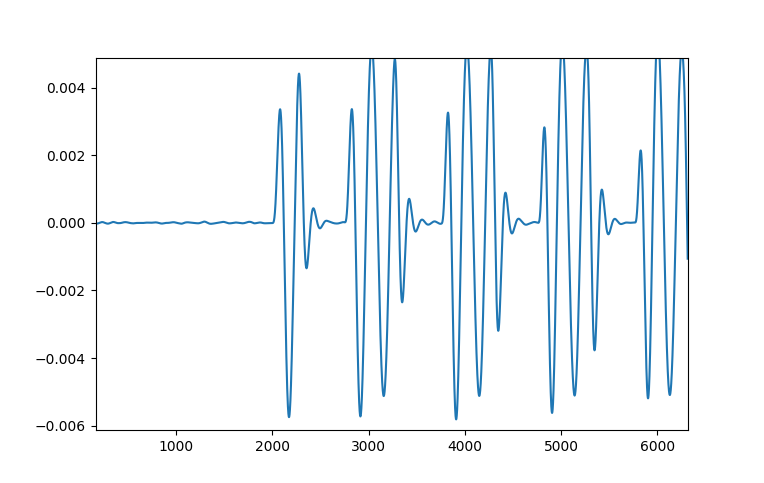

[2148 2149 2150 2151 2152 2153 2154 2155 2156 2157 2158 2159 2160 2161
 2162 2163 2164 2165 2166 2167]
[ 0.01249999-0.00312501j -0.07343751+0.08281249j -0.10468751+0.19999999j
 -0.03437501+0.19999999j -0.05000001+0.20781249j -0.08125001+0.19218749j
 -0.10468751+0.18437499j -0.10468751+0.17656249j -0.10468751+0.18437499j
 -0.13593751+0.16874999j -0.15937501+0.13749999j]
[-1.49294900e-04-0.00092251j -1.40387228e-04-0.00092513j
 -1.31758287e-04-0.00092718j -1.23460631e-04-0.00092858j
 -1.15583272e-04-0.00092919j -1.08260142e-04-0.00092872j
 -1.01678771e-04-0.00092677j -9.60912311e-05-0.00092276j
 -9.18259635e-05-0.00091593j -8.92993516e-05-0.00090533j
 -8.90277293e-05-0.00088985j]
[-1.07553400e-05+7.57149028e-06j -1.06553394e-05+7.14615508e-06j
 -1.05298839e-05+6.69988238e-06j -1.03818801e-05+6.23390827e-06j
 -1.02142758e-05+5.75013821e-06j -1.00296759e-05+5.25110420e-06j
 -9.83037222e-06+4.73980157e-06j -9.61825363e-06+4.21930521e-06j
 -9.39443531e-06+3.69220152e-06j -9.15877167e-06+3.15

<IPython.core.display.Javascript object>


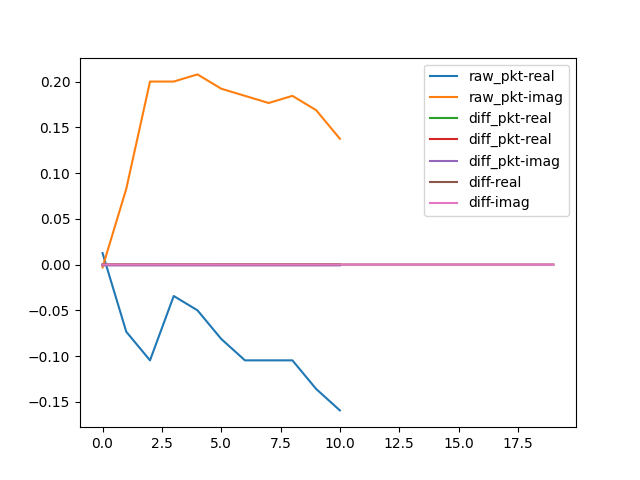

(-0.07343751+0.08281249j)
(-0.0001403872284700353-0.000925127944256726j)
(-8.907671361719447e-06+2.6179227209565054e-06j)


<IPython.core.display.Javascript object>


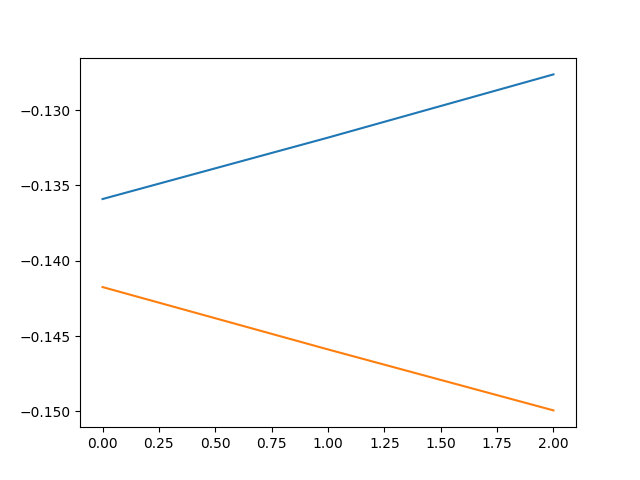

<IPython.core.display.Javascript object>


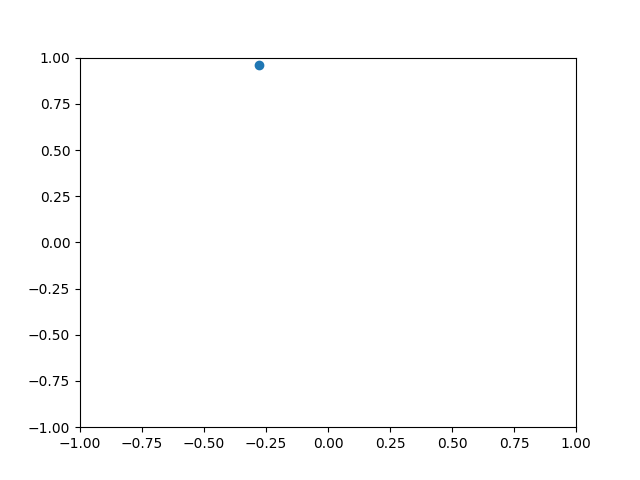

<function matplotlib.pyplot.show(block=None)>

In [110]:
#Method 2 of bit isolations using derivative
#I have abandoned method 2 because it took too much time and method 1 works ok.
# added a LPF IOT to make results more consistent

DIFF_TRESH = .004

filt_pkt = lpf(raw_pkt, fs, 246)
diff_pkt = np.roll(filt_pkt, -1)    #diff_pkt is a copy of raw_pkt shifted 1 to the left

diff_pkt[-1] = filt_pkt[-1] 
diff = filt_pkt - diff_pkt


x_diff = range(diff.size)

%matplotlib notebook
plt.figure(6)
plt.plot(x_diff, diff.real)
plt.show()

tx =abs(diff.real)>=DIFF_TRESH 

bit_loc = np.where(tx == True)[0] #locations where value non-zero
print(bit_loc[0:20])
start_bit = bit_loc[0] 
end_bit = bit_loc[1] + 2

print(raw_pkt[1999:2010])
print(diff_pkt[1999:2010])
print(diff[1990:2010])
print(bit_loc[0])

plt.figure(9)
plt.plot(range(raw_pkt[1999:2010].size), raw_pkt[1999:2010].real, label='raw_pkt-real')
plt.plot(range(raw_pkt[1999:2010].size), raw_pkt[1999:2010].imag, label='raw_pkt-imag')
plt.plot(range(diff_pkt[1999:2010].size), diff_pkt[1999:2010].real, label='diff_pkt-real')
plt.plot(range(diff_pkt[1999:2010].size), diff_pkt[1999:2010].real, label='diff_pkt-real')
plt.plot(range(diff_pkt[1999:2010].size), diff_pkt[1999:2010].imag, label='diff_pkt-imag')
plt.plot(range(diff[1990:2010].size), diff[1990:2010].real, label='diff-real')
plt.plot(range(diff[1990:2010].size), diff[1990:2010].imag, label='diff-imag')
plt.legend()
plt.show()

print(raw_pkt[2000])
print(diff_pkt[2000])
print(diff[2000])

bit_msg = filt_pkt[start_bit:end_bit]
x_diff = range(bit_msg.size)

plt.figure(7)
plt.plot(x_diff, bit_msg.real, x_diff, bit_msg.imag)
plt.show()

plt.figure(8)
plt.xlim(-1,1)
plt.ylim(-1,1)
symb = np.sum(raw_bit)
symb = symb / abs(symb)
plt.scatter(symb.real, symb.imag)
plt.show